In [180]:
from shapely.geometry import mapping, Polygon
import fiona

# You can see a schema as column names and types of a table which holds all the data (see bellow)

schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Here are polygons which define our map

class maison():
    shape = None
    shadow = None

    def __init__(self,shape,shadow):
        self.shape = shape #shape
        self.shadow = shadow
    
    '''
    write in a json file the shapes of house
    '''
    def export_json(self, filename):
        with fiona.open(filename, 'w', 'GeoJSON', schema) as c:
            c.write({
                'geometry': mapping(self.shadow),
                'properties': {'id': 1},
            })
            c.write({
                'geometry': mapping(self.shape),
                'properties': {'id': 2},
            })
        return filename

poly2 = Polygon([(1, 1),(4,1), (4,4), (1,4)]) #shadow
poly1 = Polygon([(1, 1.2),(3.9,1.2), (3.9,4), (1,4)]) #shape
maison1 = maison(poly1,poly2)
print(maison1.export_json("/tmp/my_shp2.json"))

/tmp/my_shp2.json


In [181]:
!cat /tmp/my_shp2.json

{
"type": "FeatureCollection",
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1.0, 1.0 ], [ 4.0, 1.0 ], [ 4.0, 4.0 ], [ 1.0, 4.0 ], [ 1.0, 1.0 ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1.0, 1.2 ], [ 3.9, 1.2 ], [ 3.9, 4.0 ], [ 1.0, 4.0 ], [ 1.0, 1.2 ] ] ] } }
]
}


In [182]:
import json

with open('/tmp/my_shp2.json') as f:
    data = json.load(f)
    
data

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'id': 1},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[1.0, 1.0],
      [4.0, 1.0],
      [4.0, 4.0],
      [1.0, 4.0],
      [1.0, 1.0]]]}},
  {'type': 'Feature',
   'properties': {'id': 2},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[1.0, 1.2],
      [3.9, 1.2],
      [3.9, 4.0],
      [1.0, 4.0],
      [1.0, 1.2]]]}}]}

<AxesSubplot:>

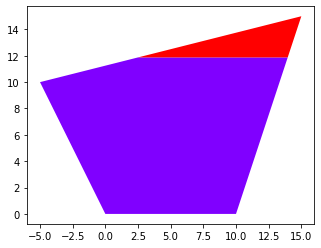

In [6]:
import geopandas as gpd

shapes = gpd.read_file('/tmp/house_class.json')
shapes.plot(cmap="rainbow")   # arg column is used to define colors, cmap maps column values to colors

(-50.0, 0.0, 150.0, 150.0)


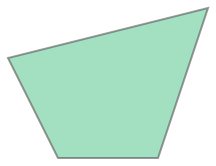

In [61]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import mapping, Polygon, Point, LineString, MultiPolygon
import numpy as np


poly = Polygon([(0,0), (100,0), (150,150), (-50,100)])
print(poly.bounds)
poly

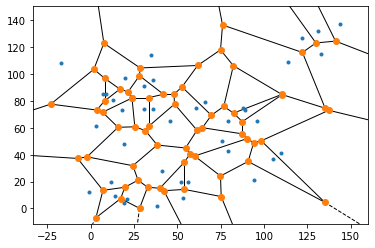

In [64]:
import random as r 
HOUSES_MAX = 40
def partition(poly):
    (min_x,min_y,max_x,max_y) = poly.bounds
    nb = 0
    points = []
    while(nb < HOUSES_MAX):
        x = r.randint(min_x, max_x)
        y = r.randint(min_y, max_y)
        if (poly.contains(Point(x,y))):
            points.append((x,y))
            nb+=1
    return points

points = partition(poly)
vor = Voronoi(points)
voronoi_plot_2d(vor);

[<shapely.geometry.polygon.Polygon object at 0x7f8780ffe9a0>, <shapely.geometry.polygon.Polygon object at 0x7f8780f155e0>, <shapely.geometry.polygon.Polygon object at 0x7f8780f15790>, <shapely.geometry.polygon.Polygon object at 0x7f8780f15f70>, <shapely.geometry.polygon.Polygon object at 0x7f8780f15e50>, <shapely.geometry.polygon.Polygon object at 0x7f8780f15ee0>, <shapely.geometry.polygon.Polygon object at 0x7f8780f15700>, <shapely.geometry.polygon.Polygon object at 0x7f8780f15580>, <shapely.geometry.polygon.Polygon object at 0x7f8780f15af0>, <shapely.geometry.polygon.Polygon object at 0x7f8780f15550>, <shapely.geometry.polygon.Polygon object at 0x7f8780f15850>, <shapely.geometry.polygon.Polygon object at 0x7f8780c34280>, <shapely.geometry.polygon.Polygon object at 0x7f8780c342b0>, <shapely.geometry.polygon.Polygon object at 0x7f8780c342e0>, <shapely.geometry.polygon.Polygon object at 0x7f8780c34340>, <shapely.geometry.polygon.Polygon object at 0x7f8780c34370>, <shapely.geometry.polyg

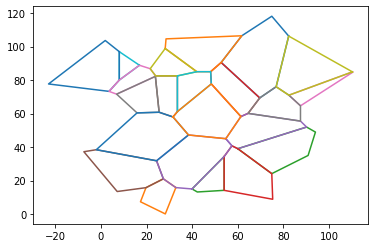

In [67]:
def get_sub_parts(vor, poly):
    regions = [r for r in vor.regions if -1 not in r and len(r) > 0]
    regions = [Polygon([vor.vertices[i] for i in r]) for r in regions]
    regions = [r for r in regions if poly.contains(r) ]

for r in get_sub_parts(vor,):
    plt.plot(*r.exterior.xy)